In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
# from sklearn.model_selection import GridSearchCV
# from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
# Join citibike data and weather data based on date
weather_data = pd.read_csv('./Data/Weather/cleaned_weather.csv')
citi_data = pd.read_csv('./Data/Citi_Bike/reduced_data.csv')

weather_data['Date'] = pd.to_datetime(weather_data['Date']).dt.date
citi_data['Date'] = pd.to_datetime(citi_data['started_at']).dt.date
data = citi_data.merge(weather_data, on='Date', how='left').dropna()
data['Date'] = pd.to_datetime(data['Date'])

data.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,48.384615
1,1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,45.769231
2,2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,53.307692
3,3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,41.769231
4,4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,42.384615


In [3]:
data.dtypes

Unnamed: 0                     int64
ride_id                       object
rideable_type                 object
started_at                    object
ended_at                      object
start_station_name            object
end_station_name              object
member_casual                 object
Date                  datetime64[ns]
AWND                         float64
PRCP                         float64
SNOW                         float64
SNWD                         float64
TAVG                         float64
TMAX                         float64
TMIN                         float64
dtype: object

In [4]:
# split datetime into three columns: year, month, and day.
data['Date'] = pd.to_datetime(data['Date'])
data['year']=data['Date'].dt.year
data['month']=data['Date'].dt.month
data['day']=data['Date'].dt.day

In [5]:
#create season feature
data['date_offset'] = (data.Date.dt.month*100 + data.Date.dt.day - 320)%1300

data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

In [6]:
data["year"].value_counts().values[0]
data.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,...,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,date_offset,season
0,0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.78750,...,0.0,0.0,58.333333,63.538462,48.384615,2021,5,6,186,spring
1,1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.23625,...,0.0,0.0,61.333333,69.076923,45.769231,2021,5,13,193,spring
2,2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.31250,...,0.0,0.0,66.000000,75.769231,53.307692,2021,5,16,196,spring
3,3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.64375,...,0.0,0.0,53.333333,65.692308,41.769231,2021,5,1,181,spring
4,4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.77125,...,0.0,0.0,52.666667,59.846154,42.384615,2021,5,9,189,spring


In [7]:
df = data.copy()
df.drop(['Unnamed: 0', 'rideable_type', 'start_station_name', 'end_station_name', 'member_casual'], axis=1, inplace=True)

In [8]:
df.head()

,ride_id,started_at,ended_at,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,date_offset,season
0,E12103A91226099A,2021-05-06 17:25:01,2021-05-06 17:45:25,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,48.384615,2021,5,6,186,spring
1,26A3DC47FE0EA3A3,2021-05-13 12:48:08,2021-05-13 13:07:37,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,45.769231,2021,5,13,193,spring
2,A99F2E1D627B088F,2021-05-16 08:30:13,2021-05-16 08:45:47,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,53.307692,2021,5,16,196,spring
3,43E79A45997B7390,2021-05-01 08:38:14,2021-05-01 08:54:27,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,41.769231,2021,5,1,181,spring
4,8B3CC649F4F58816,2021-05-09 08:12:31,2021-05-09 08:27:05,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,42.384615,2021,5,9,189,spring


In [9]:
value_counts = df['Date'].value_counts()
value_counts

2022-09-14    138504
2022-09-08    138130
2022-09-10    137958
2022-09-09    137027
2022-09-21    136961
               ...  
2021-08-22     15755
2022-12-24     12461
2022-12-25      9753
2022-01-30      9583
2022-01-29      2888
Name: Date, Length: 760, dtype: int64

In [10]:
value_counts = df['Date'].value_counts()
df['total_rentals_per_day'] = df['Date'].map(value_counts)

In [11]:
df.drop(['date_offset'], axis=1, inplace=True)
df.drop(['ride_id', 'started_at', 'ended_at'], axis=1, inplace=True)

In [12]:
#check if the count is consistant
date_filter = df['Date'] == pd.to_datetime('2021-09-01')
filtered_df = df[date_filter]
filtered_df

,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,season,total_rentals_per_day
24910969,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
24911025,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
24911053,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
24911142,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
24911222,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28175409,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
28175449,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
28175467,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554
28175549,2021-09-01,10.96,0.654043,0.0,0.0,75.0,79.769231,65.615385,2021,9,1,summer,50554


In [13]:
df.drop_duplicates(subset='Date', inplace=True)

In [14]:
df.head()

,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,season,total_rentals_per_day
0,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,48.384615,2021,5,6,spring,93081
1,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,45.769231,2021,5,13,spring,100461
2,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,53.307692,2021,5,16,spring,97004
3,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,41.769231,2021,5,1,spring,92680
4,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,42.384615,2021,5,9,spring,53249


In [15]:
value_counts = df['Date'].value_counts()
value_counts

2021-05-06    1
2022-02-17    1
2022-02-16    1
2022-02-01    1
2022-02-19    1
             ..
2023-04-11    1
2023-04-05    1
2023-04-06    1
2023-04-07    1
2022-04-19    1
Name: Date, Length: 760, dtype: int64

### Missing values

In [16]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,date_offset,season
0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,48.384615,2021,5,6,186,spring
1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,45.769231,2021,5,13,193,spring
2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,53.307692,2021,5,16,196,spring
3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,41.769231,2021,5,1,181,spring
4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,42.384615,2021,5,9,189,spring


In [17]:
missing_number = data.isnull().sum().sort_values(ascending=False)
missing_percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['missNum', 'missPercent'])

print(missing_values)

                    missNum  missPercent
season               138135     0.002174
rideable_type             0     0.000000
date_offset               0     0.000000
day                       0     0.000000
month                     0     0.000000
year                      0     0.000000
TMIN                      0     0.000000
TMAX                      0     0.000000
TAVG                      0     0.000000
SNWD                      0     0.000000
ride_id                   0     0.000000
PRCP                      0     0.000000
AWND                      0     0.000000
Date                      0     0.000000
member_casual             0     0.000000
end_station_name          0     0.000000
start_station_name        0     0.000000
ended_at                  0     0.000000
started_at                0     0.000000
SNOW                      0     0.000000


### Outliers

In [18]:
df.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,total_rentals_per_day
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,7.988500,0.142351,0.034051,0.082428,57.382895,64.414192,47.483929,2021.796053,6.426316,15.711842,83611.230263
std,3.026594,0.364408,0.322345,0.578235,16.265790,16.818014,15.890149,0.691934,3.416976,8.796626,29844.690614
min,2.292500,0.000000,0.000000,0.000000,11.000000,22.923077,3.428571,2021.000000,1.000000,1.000000,2888.000000
25%,5.815937,0.000336,0.000000,0.000000,44.666667,51.076923,34.928571,2021.000000,4.000000,8.000000,61648.500000
50%,7.354653,0.014759,0.000000,0.000000,57.000000,64.919872,46.269231,2022.000000,6.000000,16.000000,85960.500000
75%,9.646562,0.107424,0.000000,0.000000,71.750000,79.000000,61.017857,2022.000000,9.000000,23.000000,108837.250000
max,20.048750,5.291300,5.624528,7.607500,88.000000,96.538462,77.615385,2023.000000,12.000000,31.000000,138504.000000


### Correlation Heatmap

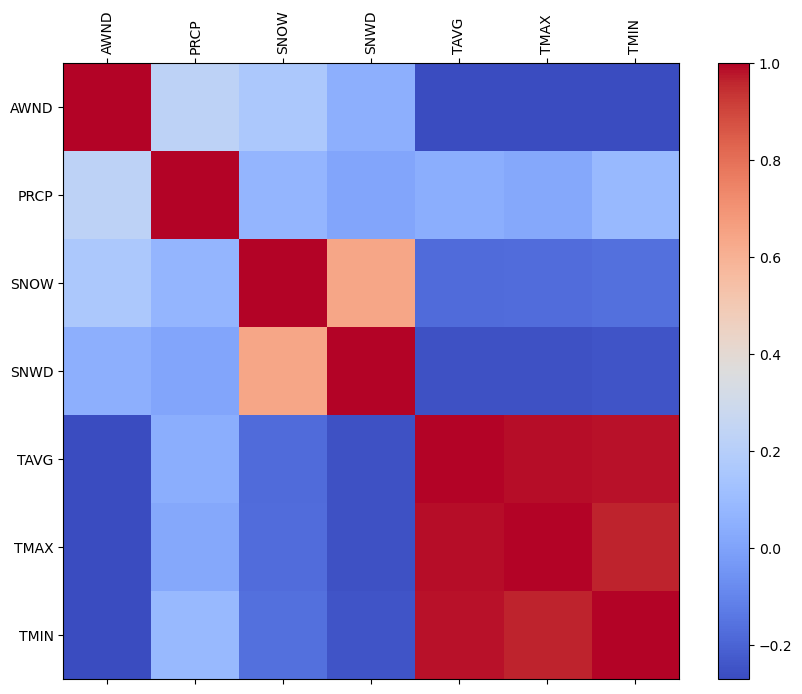

In [19]:
# def correlation_heatmap(corr):
#     mask = np.array(corr)
#     mask[np.tril_indices_from(mask)] = False
#     fig,ax= plt.subplots()
#     fig.set_size_inches(20,10)
#     sn.heatmap(corr, annot=True, mask=mask)

def correlation_heatmap(corr):
    mask = np.tril(corr)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    cax = ax.matshow(corr, cmap='coolwarm')
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

corr = df[['AWND', 'PRCP','SNOW', 'SNWD','TAVG', 'TMAX','TMIN', 'season']].corr()
correlation_heatmap(corr)

After analyzing the dataset, we found that all features except for three temperature-related features, namely 'max_temperature', 'min_temperature', and 'average_temperature', appear to be fine. However, these temperature features exhibit a high degree of correlation among themselves. To address this issue, we have decided to drop two of the temperature features.

High correlation between these temperature features suggests that they provide similar information, leading to redundancy in our data. By removing two of the highly correlated features, we aim to reduce multicollinearity and potential overfitting in our model.

To make the decision on which features to drop, we calculated the correlation matrix for the temperature features. The correlation coefficient between 'max_temperature' and 'min_temperature' was found to be above our predefined threshold of 0.9. Consequently, we decided to drop one of these features based on our domain knowledge or specific modeling requirements.

In [20]:
# Decide which feature(s) to drop
corr_matrix = df[['TMAX', 'TMIN', 'TAVG']].corr()
threshold = 0.9  

if corr_matrix.loc['TMAX', 'TMIN'] >= threshold:
    # 'max_temperature' and 'min_temperature' are highly correlated
    df.drop('TMIN', axis=1, inplace=True)
elif corr_matrix.loc['TMAX', 'TAVG'] >= threshold:
    # 'max_temperature' and 'average_temperature' are highly correlated
    df.drop('TAVG', axis=1, inplace=True)

In [21]:
df.head()

,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,year,month,day,season,total_rentals_per_day
0,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,2021,5,6,spring,93081
1,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,2021,5,13,spring,100461
2,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,2021,5,16,spring,97004
3,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,2021,5,1,spring,92680
4,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,2021,5,9,spring,53249


### Modelling

In [22]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,date_offset,season
0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.787500,0.292644,0.0,0.0,58.333333,63.538462,48.384615,2021,5,6,186,spring
1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.236250,0.000000,0.0,0.0,61.333333,69.076923,45.769231,2021,5,13,193,spring
2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.312500,0.000235,0.0,0.0,66.000000,75.769231,53.307692,2021,5,16,196,spring
3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.643750,0.016375,0.0,0.0,53.333333,65.692308,41.769231,2021,5,1,181,spring
4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.771250,0.301707,0.0,0.0,52.666667,59.846154,42.384615,2021,5,9,189,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63544530,5EBE9D296B9D3E3C,classic_bike,2022-04-22 13:08:15,2022-04-22 13:29:31,Allen St & Rivington St,W 29 St & 9 Ave,member,2022-04-22,8.922222,0.000253,0.0,0.0,58.666667,66.071429,45.357143,2022,4,22,102,spring
63544531,B66382DEDA84C464,classic_bike,2022-04-13 17:10:49,2022-04-13 17:26:08,St. Nicholas Terrace & Convent Ave,E 138 St & Grand Concourse,member,2022-04-13,5.957500,0.035949,0.0,0.0,59.000000,70.153846,47.923077,2022,4,13,93,spring
63544532,9EC4C49BE4CB1A09,classic_bike,2022-04-12 15:58:47,2022-04-12 16:41:17,E 88 St & 1 Ave,E 91 St & 2 Ave,member,2022-04-12,5.838889,0.016628,0.0,0.0,56.000000,66.076923,44.692308,2022,4,12,92,spring
63544533,C0188AB9FAEAA143,electric_bike,2022-04-28 15:52:49,2022-04-28 16:06:31,W 55 St & 6 Ave,E 91 St & 2 Ave,member,2022-04-28,15.483333,0.000000,0.0,0.0,47.666667,57.500000,40.000000,2022,4,28,108,spring


In [23]:
citi_data.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date
0,0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06
1,1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13
2,2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16
3,3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01
4,4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09


In [34]:
# df_station_demand = pd.DataFrame(columns = ["station_name", "date", ""])
# station_rental_ct = citi_data.start_station_name.value_counts()
# for row in citi_data.iterrows():
#     df_station_demand[]
# print(citi_data.start_station_name.value_counts())

count_series = citi_data.groupby(['start_station_name', 'Date']).size()
new_df = count_series.to_frame(name = 'rental_count').reset_index()

,start_station_name,Date,rental_count
0,1 Ave & E 110 St,2021-04-01,41
1,1 Ave & E 110 St,2021-04-02,38
2,1 Ave & E 110 St,2021-04-03,50
3,1 Ave & E 110 St,2021-04-04,45
4,1 Ave & E 110 St,2021-04-05,56
...,...,...,...
1152736,Yankee Ferry Terminal,2023-04-24,21
1152737,Yankee Ferry Terminal,2023-04-25,17
1152738,Yankee Ferry Terminal,2023-04-26,9
1152739,Yankee Ferry Terminal,2023-04-27,9


In [35]:
new_data = new_df.merge(weather_data, on='Date', how='left').dropna()
new_data

,start_station_name,Date,rental_count,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,1 Ave & E 110 St,2021-04-01,41,15.63125,0.452921,0.0,0.0,49.000000,59.076923,39.307692
1,1 Ave & E 110 St,2021-04-02,38,12.83500,0.025000,0.0,0.0,36.000000,43.461538,27.923077
2,1 Ave & E 110 St,2021-04-03,50,7.68875,0.000494,0.0,0.0,40.000000,47.153846,29.153846
3,1 Ave & E 110 St,2021-04-04,45,5.98375,0.000116,0.0,0.0,50.000000,58.538462,36.384615
4,1 Ave & E 110 St,2021-04-05,56,14.31625,0.000000,0.0,0.0,57.000000,65.538462,42.769231
...,...,...,...,...,...,...,...,...,...,...
1152736,Yankee Ferry Terminal,2023-04-24,21,6.99000,0.145125,0.0,0.0,54.000000,63.076923,43.153846
1152737,Yankee Ferry Terminal,2023-04-25,17,5.53625,0.000267,0.0,0.0,53.333333,59.846154,42.692308
1152738,Yankee Ferry Terminal,2023-04-26,9,6.54375,0.002308,0.0,0.0,52.000000,58.307692,40.230769
1152739,Yankee Ferry Terminal,2023-04-27,9,5.06250,0.029875,0.0,0.0,53.333333,57.923077,44.461538


In [39]:
x = new_data[['TAVG', 'SNOW', 'PRCP', 'start_station_name']]
y = new_data['rental_count']

# Encode categorical station data
label_encoder = LabelEncoder()
x['start_station_name'] = label_encoder.fit_transform(x['start_station_name'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

,TAVG,SNOW,PRCP,start_station_name
716708,59.000000,0.000000,0.594045,1197
484095,73.333333,0.000000,0.035595,816
997238,36.666667,0.012245,0.003125,1698
1091298,51.000000,0.000000,0.033125,1847
435544,39.666667,0.000000,0.000366,742
...,...,...,...,...
110268,38.666667,0.007042,0.116778,160
259178,55.000000,0.000000,0.016265,454
131932,73.000000,0.000000,0.000256,201
671155,65.666667,0.000000,0.007065,1124


In [43]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(x_train, y_train)
y_pred = random_forest_model.predict(x_test)

relation_square:  0.9696748223568423


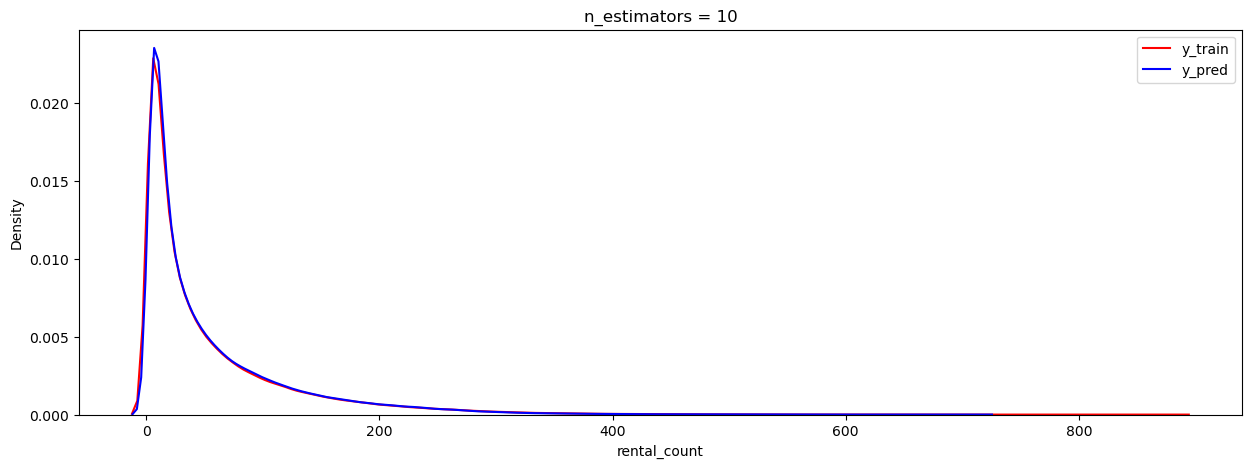

relation_square:  0.9732746927409673


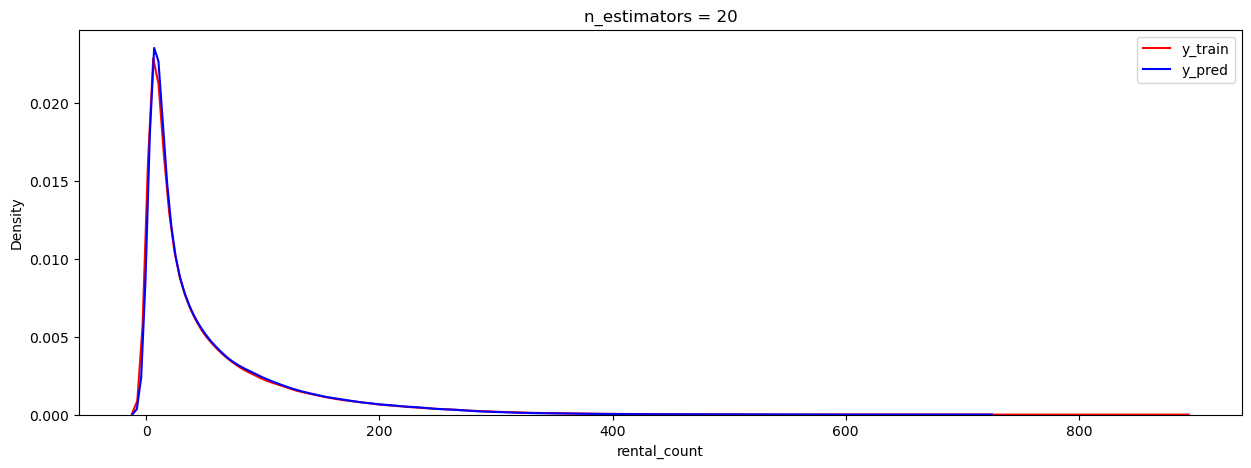

relation_square:  0.9753575780862946


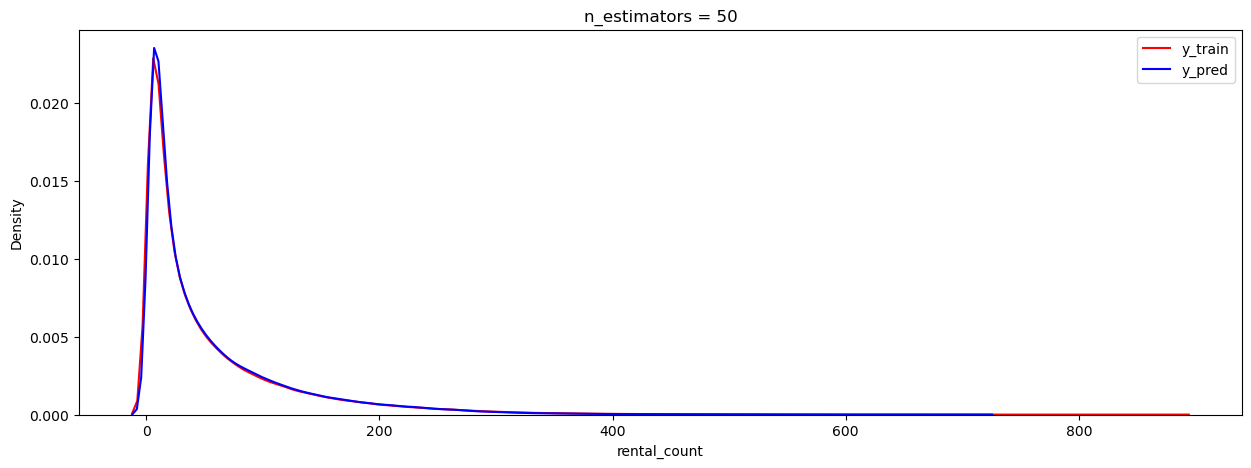

relation_square:  0.9760633026384353


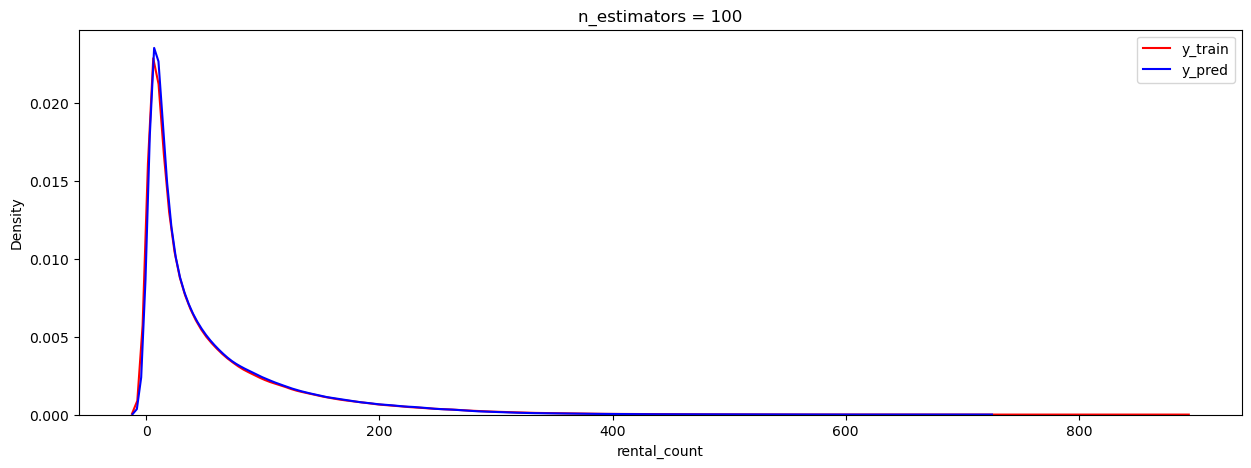

relation_square:  0.9763002979817471


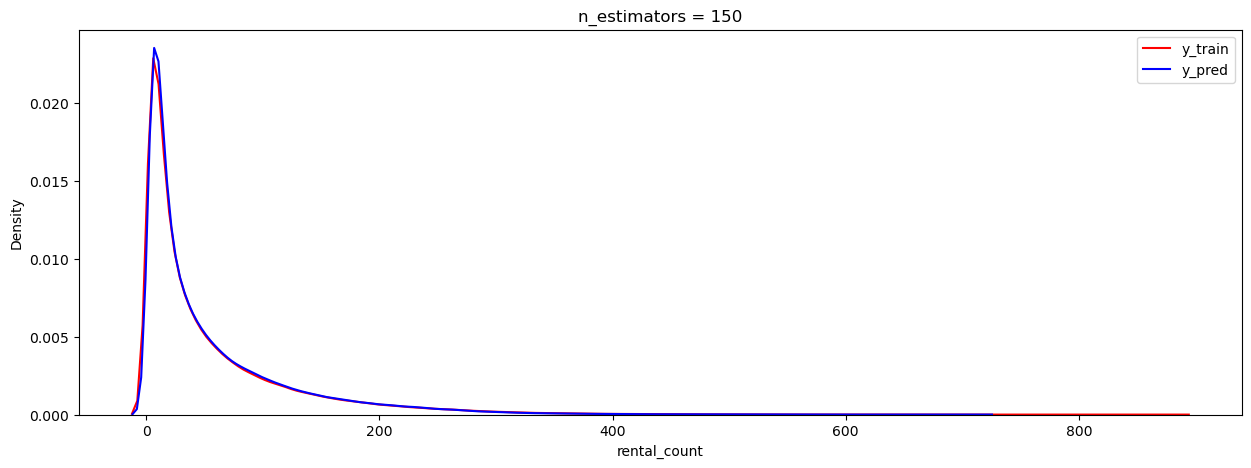

relation_square:  0.9764206281493814


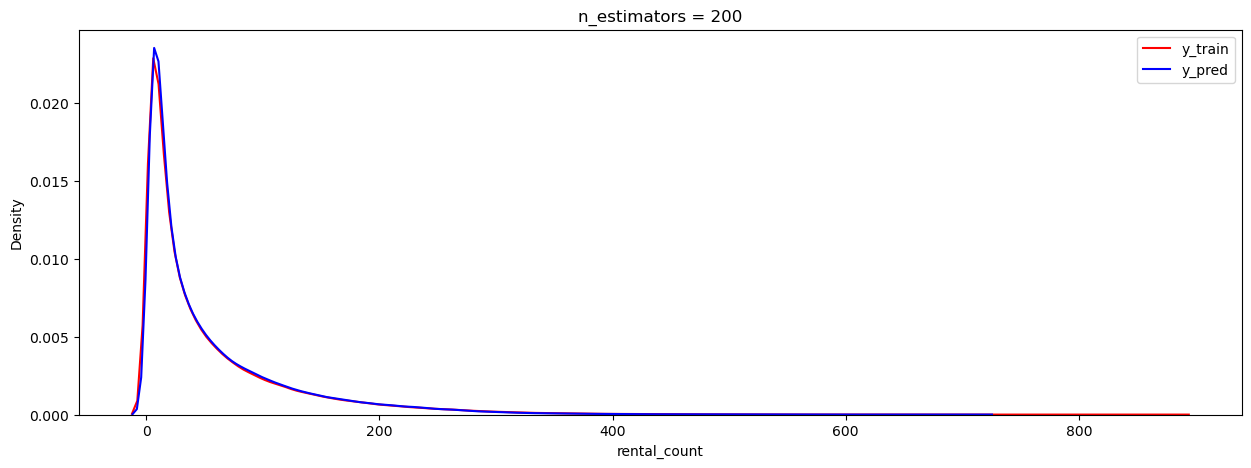

In [53]:
for i in (10, 20, 50, 100, 150, 200):
    random_forest_model = RandomForestRegressor(n_estimators= i,n_jobs= -1, random_state = 15)
    random_forest_model.fit(x_train,y_train)
    y_predict = random_forest_model.predict(x_train)

    relation_square = random_forest_model.score(x_train, y_train)
    print('relation_square: ', relation_square)
    plt.figure(figsize=(15,5))

    ax1 = sns.kdeplot(y_train,label = 'y_train',color="red")
    ax2 = sns.kdeplot(y_p,label = 'y_pred',color="blue")
    
    title = "n_estimators = " + str(i)
    plt.title(title)
    plt.legend()
    plt.show()

It turned out that when n_estimators = 200, the score is the highest. Therefore we are going to continue with n_estimators = 200 below:

In [54]:
random_forest_best_model = RandomForestRegressor(n_estimators = 200, n_jobs = -1 , random_state = 0)
random_forest_best_model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=0)

In [55]:
random_forest_best_pred = random_forest_best_model.predict(x_test)
random_forest_best_pred

array([18.98  , 66.864 ,  5.71  , ..., 39.22  ,  8.2225, 63.255 ])

In [70]:
mse_random_forest = mean_squared_error(y_test, random_forest_best_pred)
root_mse_random_forest = np.sqrt(mse_random_forest)
print("Root Mean Squared Error: " + str(root_mse_random_forest))


Root Mean Squared Error: 26.330268362225283


#### XGBOOST

In [68]:
xgb_model = xgb.XGBRegressor(random_state = 0)
xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)

In [71]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
root_mse_xgb = np.sqrt(mse_xgb)
print("Root Mean Squared Error: " + str(root_mse_xgb))

Root Mean Squared Error: 32.47747583491521


In [48]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(x_train, y_train)
logistic_model.score(x_train, y_train)

/Users/xinningfang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.031045595711088364